# Running Ratio of EUV Wave Images

## Will Barnes (with many thanks to Wei Liu)

In this notebook, we'll demonstrate how to compute the running ratio for various EUV images in order to visualize the resulting EUV wave from the September 10th 2017 flaring event. This notebook partially follows the analysis of [Liu et al. (2018)](https://doi.org/10.3847/2041-8213/aad77b).

In [3]:
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)
import sys
import os
import traceback

import yaml
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation
from IPython.display import HTML
from astropy.visualization import ImageNormalize,AsinhStretch
import dask
import dask.array as da
import distributed
from dask_jobqueue import PBSCluster
import astropy.units as u
import sunpy.map
import ndcube

import aiacube
from aiacube.prep import register_and_derotate

sys.path.append('../../scripts/')
from drms_on_ames import Client

plt.rcParams['animation.embed_limit'] = 500

%matplotlib inline

## Query Data

Grab AIA 171 data for 2 hours around the start of the flare.

In [4]:
c = Client(ssh=True)

In [5]:
key, q = c.query(
    'aia.lev1[2017-09-10T15:30:00/2h]',
    seg=['image_lev1'],
    key=['WAVELNTH']
)
files = (q[(key['WAVELNTH']==171)
           | (key['WAVELNTH']==193)
           | (key['WAVELNTH']==211)
          ]
         .values
         .squeeze()
         .tolist()
        )

In [6]:
files

['/nobackup/drms/SUM5/D969636800/S00000/image_lev1.fits',
 '/nobackup/drms/SUM1/D969636803/S00000/image_lev1.fits',
 '/nobackup/drms/SUM4/D969636804/S00000/image_lev1.fits',
 '/nobackup/drms/SUM1/D969636808/S00000/image_lev1.fits',
 '/nobackup/drms/SUM6/D969636811/S00000/image_lev1.fits',
 '/nobackup/drms/SUM2/D969636816/S00000/image_lev1.fits',
 '/nobackup/drms/SUM5/D969636820/S00000/image_lev1.fits',
 '/nobackup/drms/SUM2/D969636823/S00000/image_lev1.fits',
 '/nobackup/drms/SUM4/D969636824/S00000/image_lev1.fits',
 '/nobackup/drms/SUM2/D969636851/S00000/image_lev1.fits',
 '/nobackup/drms/SUM1/D969636854/S00000/image_lev1.fits',
 '/nobackup/drms/SUM2/D969636855/S00000/image_lev1.fits',
 '/nobackup/drms/SUM3/D969636859/S00000/image_lev1.fits',
 '/nobackup/drms/SUM4/D969636862/S00000/image_lev1.fits',
 '/nobackup/drms/SUM6/D969636865/S00000/image_lev1.fits',
 '/nobackup/drms/SUM3/D969636869/S00000/image_lev1.fits',
 '/nobackup/drms/SUM5/D969636872/S00000/image_lev1.fits',
 '/nobackup/dr

## Dask Cluster
Now spin up compute cluster with Dask

In [7]:
with open('../../jobqueue-merope.yml','r') as f:
    config = yaml.load(f)['jobqueue']['pbs']

/home4/wtbarnes/miniconda3/envs/aia-on-pleiades/lib/python3.7/site-packages/ipykernel_launcher.py:2: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  


In [8]:
cluster = PBSCluster(**config)

In [9]:
client = distributed.Client(cluster)

In [10]:
cluster.scale(60) 

## Computing Level 1.5 Data Products

Read in all the Maps into the cluster memory and the headers into local memory

In [11]:
maps = client.map(sunpy.map.Map, files, pure=True)

In [12]:
headers = client.map(lambda x: x.meta, maps, pure=True)

In [13]:
headers = client.gather(headers)

Sort into channels.

In [14]:
maps_171 = [m for (m,h) in zip(maps,headers) if h['wavelnth']==171]

In [15]:
maps_193 = [m for (m,h) in zip(maps,headers) if h['wavelnth']==193]

In [16]:
maps_211 = [m for (m,h) in zip(maps,headers) if h['wavelnth']==211]

Register and derotate each channel

In [17]:
maps_171_lvl_15_derot = register_and_derotate(maps_171)

In [18]:
maps_193_lvl_15_derot = register_and_derotate(maps_193)

In [19]:
maps_211_lvl_15_derot = register_and_derotate(maps_211)

Next, we need to separate these level 1.5 maps out into the three channels and stack them into cubes.

In [21]:
cube_171 = aiacube.AIACube.from_futures(maps_171_lvl_15_derot)

In [22]:
cube_171

NDCube
---------------------
WCS Keywords

Number of WCS axes: 3
CTYPE : 'HPLN-TAN'  'HPLT-TAN'  'TIME'  
CRVAL : 0.0  0.0  0.0  
CRPIX : 2048.5  2048.5  1.0  
PC1_1 PC1_2 PC1_3  : 1.0  -5.4210108624275e-20  0.0  
PC2_1 PC2_2 PC2_3  : 0.0  1.0  0.0  
PC3_1 PC3_2 PC3_3  : 0.0  0.0  1.0  
CDELT : 0.00016666666666667  0.00016666666666667  12.00000000000188  
NAXIS : 4096  4096  600
---------------------
Length of NDCube: [ 600. 4096. 4096.] pix
Axis Types of NDCube: ('time', 'custom:pos.helioprojective.lat', 'custom:pos.helioprojective.lon')

In [23]:
cube_171.data

,Array,Chunk
Bytes,80.53 GB,134.22 MB
Shape,"(600, 4096, 4096)","(1, 4096, 4096)"
Count,1800 Tasks,600 Chunks
Type,float64,numpy.ndarray


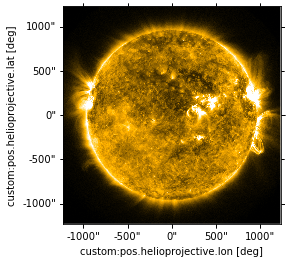

In [24]:
cube_171[0,:,:].plot(
    cmap='sdoaia171',
    norm=ImageNormalize(vmin=0, vmax=5e2, stretch=AsinhStretch())
)

In [25]:
cube_193 = aiacube.AIACube.from_futures(maps_193_lvl_15_derot)

Changed DATE-OBS from '2017-09-10 15:30:04.840' to '2017-09-10T15:30:04.840''. [astropy.wcs.wcs]


In [26]:
cube_211 = aiacube.AIACube.from_futures(maps_211_lvl_15_derot)

Changed DATE-OBS from '2017-09-10 15:30:09.630' to '2017-09-10T15:30:09.630''. [astropy.wcs.wcs]


## Running Ratio Analysis

Compute the running ratio for the 171, 193, and 211 Å channels.

In [27]:
window = 10

First, we'll rechunk our array in increments of the window along the time-axis and a single chunk over latitude and longitude. When doing the windowing, this means, we're only accessing a maximum of two chunks for any given operation which should alleviate the amount of data we are transferring between workers in the cluster.

We'll drop the `NDCube` container for now and just work with bare arrays.

In [28]:
data_171 = cube_171.data.rechunk((window,) + cube_171.data.shape[1:])

In [29]:
data_171

,Array,Chunk
Bytes,80.53 GB,1.34 GB
Shape,"(600, 4096, 4096)","(10, 4096, 4096)"
Count,1860 Tasks,60 Chunks
Type,float64,numpy.ndarray


In [30]:
data_193 = cube_193.data.rechunk((window,) + cube_193.data.shape[1:])

In [31]:
data_211 = cube_211.data.rechunk((window,) + cube_211.data.shape[1:])

Now that we've rechunked the data, we'll compute the running ratio with a 2-minute window, i.e. 10 12 second time steps.

Next, compute the numerator and denominator for the ratio and take the $\log$ for each channel.

In [32]:
def running_ratio_with_window(data, w=1):
    num = da.stack([data[i:(i + w), :, :].sum(axis=0)
                    for i in range(w, data.shape[0] - w)])
    num[num < 1.0] = 1.0
    denom = da.stack([data[(i - w):i, :, :].sum(axis=0)
                      for i in range(w, data.shape[0] - w)])
    denom[denom < 1.0] = 1.0
    return da.log(num / denom)

Note that while all of these are normal array operations, they will be lazily evaluated because we are passing in Dask array objects. This means we can spread our computation out over the entire cluster, allowing it to scale with the number of available cores.

In [33]:
ratio_171 = running_ratio_with_window(data_171, w=window)

In [34]:
ratio_193 = running_ratio_with_window(data_193, w=window)

In [35]:
ratio_211 = running_ratio_with_window(data_211, w=window)

If we want to calculate one of these, but leave it in the memory of the cluster (as opposed to bringing it into the notebook), we can use the `client.persist` method.

We'll add one more rechunk to make retrieving full images more efficient.

In [36]:
ratio_171 = ratio_171.rechunk((1,) + ratio_171.shape[1:])

In [37]:
ratio_171_mem = client.persist(ratio_171)

In [35]:
ratio_193 = ratio_193.rechunk((1,) + ratio_193.shape[1:])

In [36]:
ratio_193_mem = client.persist(ratio_193)

In [37]:
ratio_211 = ratio_211.rechunk((1,) + ratio_211.shape[1:])

In [38]:
ratio_211_mem = client.persist(ratio_211)

## Visualize

Lastly, let's animate this over the entire two-hour interval using matplotlib. 

In [41]:
def make_running_ratio_animation(data, cmap='Greys', vmin=-.1, vmax=.1, delta_frames=10):
    fig = plt.figure(figsize=(8,8))
    ax = fig.gca()
    im = ax.imshow(np.flipud(data[0,:,:]),
                   cmap=cmap,
                   vmin=vmin,
                   vmax=vmax,)
    ax.tick_params(axis='both',which='both',bottom=False, left=False,
                   labelbottom=False,labelleft=False)
    def update_plot(i):
        im.set_data(np.flipud(data[i,:,:]))
    ani = matplotlib.animation.FuncAnimation(
        fig,
        update_plot,
        frames=range(1,data.shape[0],delta_frames),
        #blit=True,
    )
    return ani

In [ ]:
ani_171 = make_running_ratio_animation(
    ratio_171_mem,
    cmap=sunpy.cm.color_tables.aia_color_table(171),
    vmin=-0.5,
    vmax=0.5,
    delta_frames=5,
)

In [ ]:
HTML(ani_171.to_jshtml())

In [ ]:
ani_193 = make_running_ratio_animation(
    ratio_193_mem,
    cmap=sunpy.cm.color_tables.aia_color_table(193),
    vmin=-0.5,
    vmax=0.5,
)

In [ ]:
HTML(ani_193.to_jshtml())

In [ ]:
ani_211 = make_running_ratio_animation(
    ratio_211_mem,
    cmap=sunpy.cm.color_tables.aia_color_table(211),
    vmin=-0.5,
    vmax=0.5,
)

In [ ]:
HTML(ani_211.to_jshtml())